# Read and check data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

(218, 178, 3)


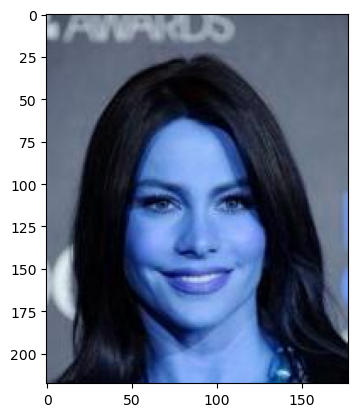

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt

image = cv.imread('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/104130.jpg')
print(image.shape)
plt.imshow(image)

# Make model and train

In [3]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define the path to your data directory
data_dir = "/kaggle/input/celeba-dataset/img_align_celeba"

# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.ToTensor()         # Convert images to tensors
])

# Create the ImageFolder dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Calculate the size of the validation set (10% of the dataset)
val_size = int(0.05 * len(dataset))
train_size = len(dataset) - val_size

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import functional as F
import torchvision.transforms.functional as TF
from torch.nn.parallel import DataParallel
from tqdm import tqdm

class UpscaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2):
        super(UpscaleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.relu(out)
        return out

# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out
    
class SRResNet(nn.Module):
    def __init__(self, num_channels=3, num_residual_blocks=16):
        super(SRResNet, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.residual_blocks = self.make_residual_blocks(num_residual_blocks, 64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.upscale_block = UpscaleBlock(64, num_channels, upscale_factor=2)
        
    def make_residual_blocks(self, num_blocks, channels):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(channels))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        residual = out
        out = self.residual_blocks(out)
        out = self.conv2(out)
        out = self.bn(out)
        out += residual
        out = self.upscale_block(out)
        return out
    
    
model = SRResNet()

# Make training loop

In [11]:

def train_model(model, train_dataloader, val_dataloader, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs for training.")
        model = DataParallel(model)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for inputs, _ in train_dataloader:
                inputs = inputs.to(device)
                inputs_target = TF.resize(inputs, size=(64, 64))

                # Resize inputs to 32x32
                inputs_downscaled = TF.resize(inputs, size=(32, 32))

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs_downscaled)

                # Compute the loss
                loss = criterion(outputs, inputs_target)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

                pbar.update(1)
                pbar.set_postfix({"Train Loss": train_loss / ((pbar.n + 1) * train_dataloader.batch_size)})

        # Calculate average training loss
        train_loss /= len(train_dataloader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            inter = 0
            for inputs, _ in val_dataloader:
                inputs = inputs.to(device)
                inputs_target = TF.resize(inputs, size=(64, 64))

                # Resize inputs to 32x32
                inputs_downscaled = TF.resize(inputs, size=(32, 32))

                outputs = model(inputs_downscaled)

                loss = criterion(outputs, inputs_target)
                val_loss += loss.item() * inputs.size(0)
                
                # Convert tensors to numpy arrays for display
                val_inputs_np = inputs_target.cpu().numpy()
                val_inputs_downscaled_np = inputs_downscaled.cpu().numpy()
                val_outputs_np = outputs.cpu().numpy()

                # Transpose the arrays to match the channel-last format (N, H, W, C)
                val_inputs_np = np.transpose(val_inputs_np, (0, 2, 3, 1))
                val_inputs_downscaled_np = np.transpose(val_inputs_downscaled_np, (0, 2, 3, 1))
                val_outputs_np = np.transpose(val_outputs_np, (0, 2, 3, 1))
                
                 # Display images using matplotlib
                for i in range(inputs.size(0)):
                    if inter < 10: 
                        fig, axes = plt.subplots(1, 3, figsize=(10, 4))
                        axes[0].imshow(val_inputs_np[i])
                        axes[0].set_title("Validation Input")
                        axes[0].axis("off")
                        axes[1].imshow(val_inputs_downscaled_np[i])
                        axes[1].set_title("Validation Input Downscaled")
                        axes[1].axis("off")
                        axes[2].imshow(val_outputs_np[i])
                        axes[2].set_title("Validation Output")
                        axes[2].axis("off")
                        plt.show()

                        inter += 1

                    else:
                        break
                
        # Calculate average validation loss
        val_loss /= len(val_dataloader.dataset)

        # Print training progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    print("Training complete.")


# Train model with display

In [6]:
num_epochs = 1
train_model(model, train_dataloader, val_dataloader, num_epochs)

Using 2 GPUs for training.


Epoch 1/1:   0%|          | 0/3008 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch 1/1: 100%|██████████| 3008/3008 [31:40<00:00,  1.58batch/s, Train Loss=0.00425]


Epoch [1/1] | Train Loss: 0.0043 | Val Loss: 0.0032
Training complete.


In [9]:
torch.save(model, "SuperUpscale_1ep.pth")        

Using 2 GPUs for training.


Epoch 1/1: 100%|██████████| 3008/3008 [15:26<00:00,  3.25batch/s, Train Loss=0.00306]


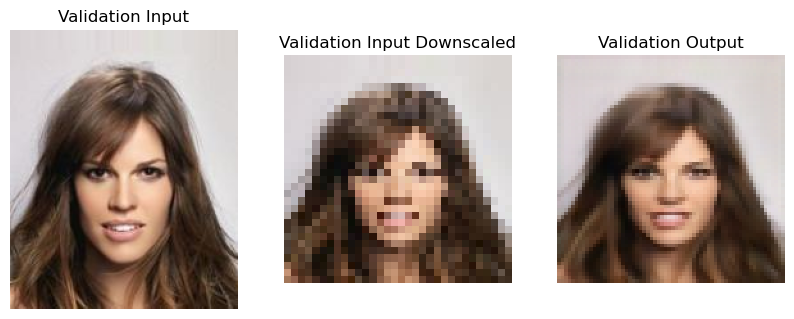

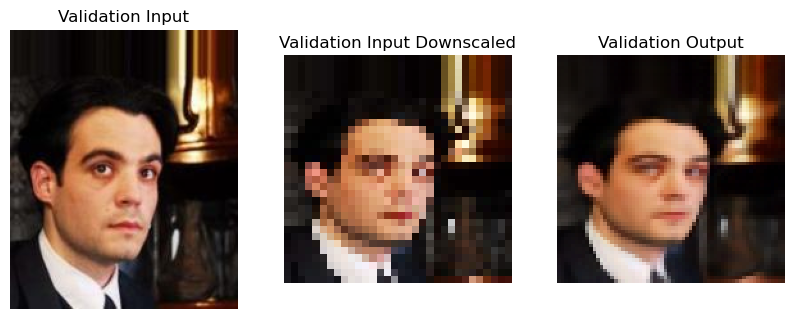

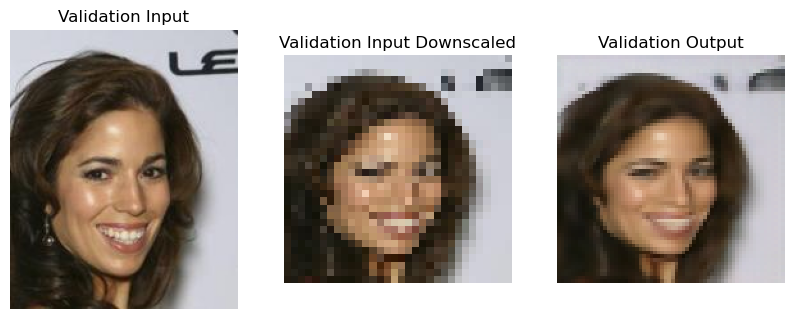

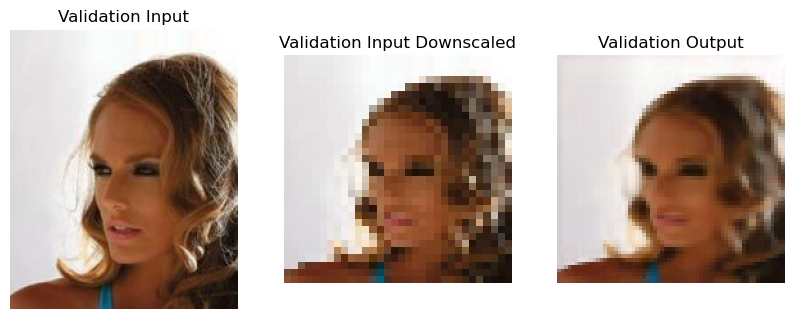

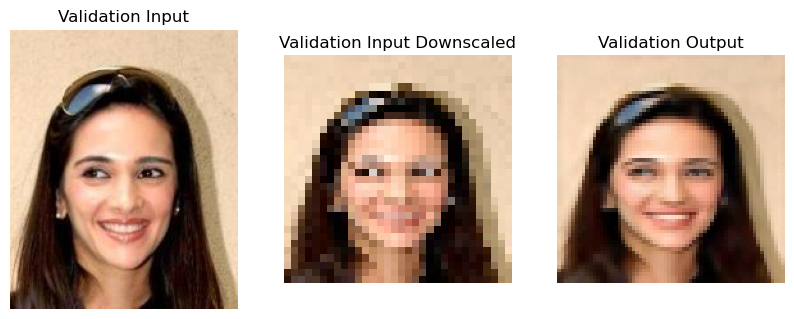

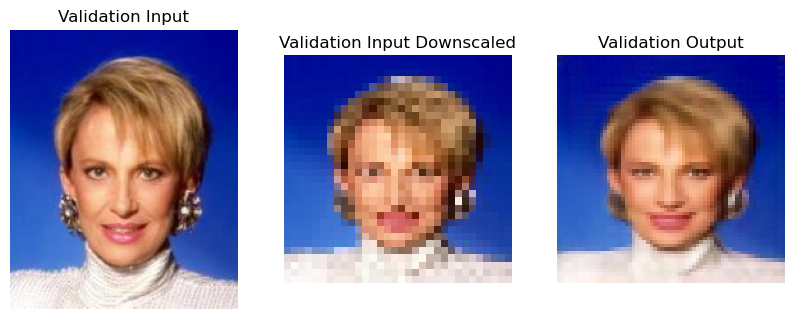

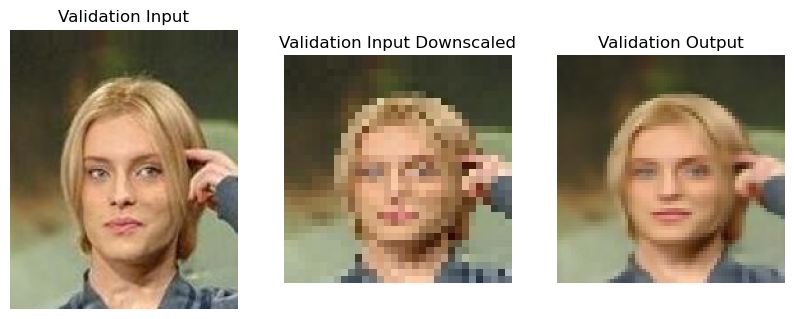

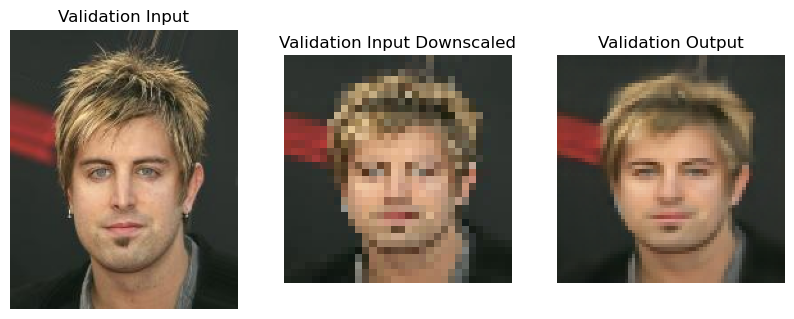

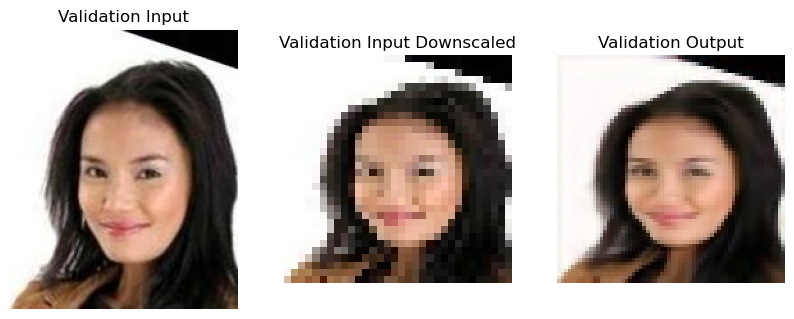

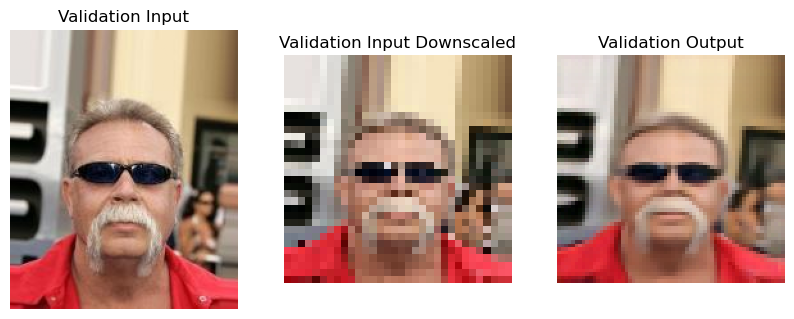

Epoch [1/1] | Train Loss: 0.0031 | Val Loss: 0.0028
Training complete.


In [10]:
num_epochs = 1
train_model(model, train_dataloader, val_dataloader, num_epochs)

Using 2 GPUs for training.


Epoch 1/1: 100%|██████████| 3008/3008 [15:10<00:00,  3.30batch/s, Train Loss=0.00784]


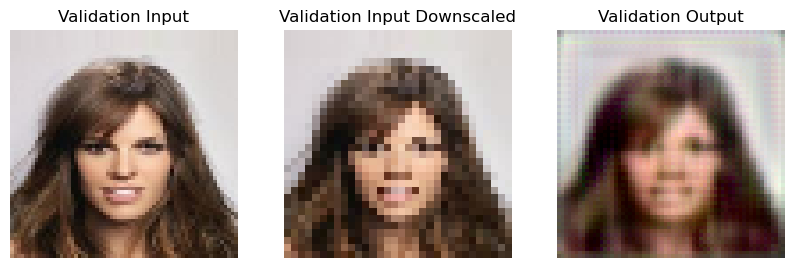

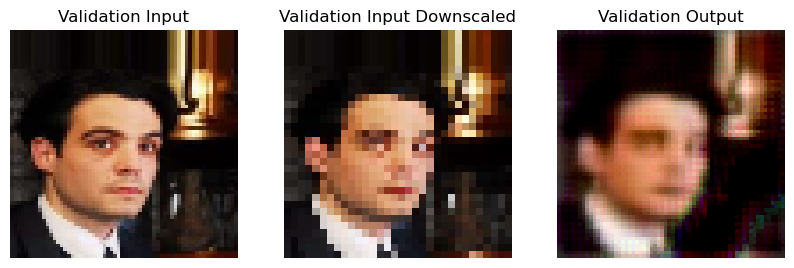

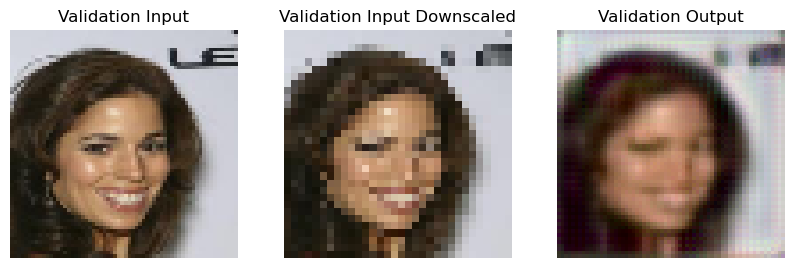

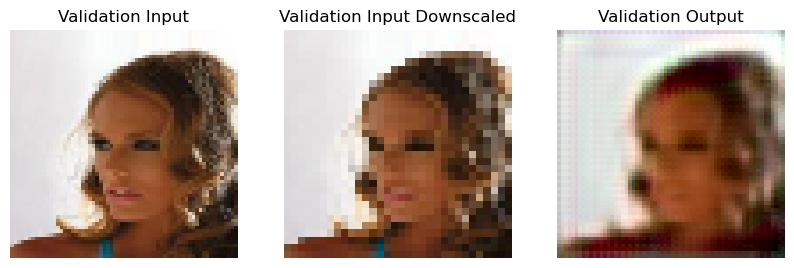

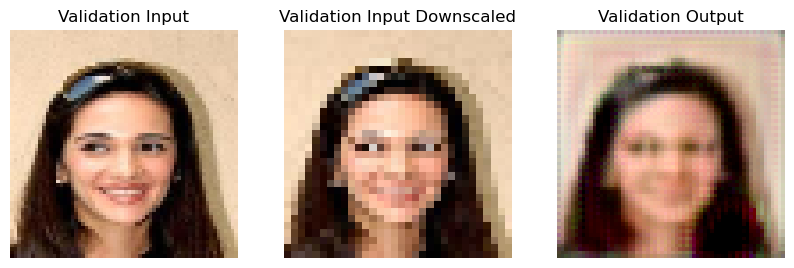

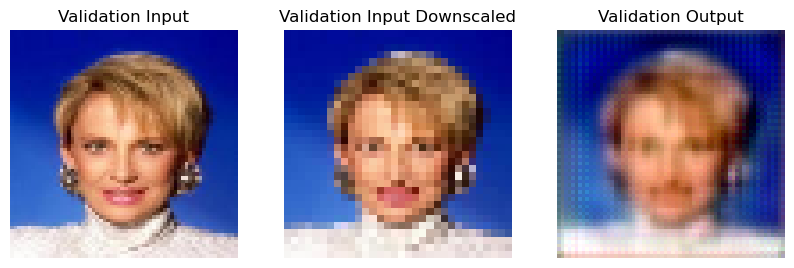

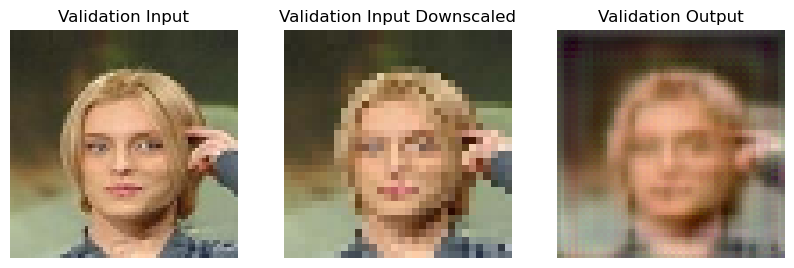

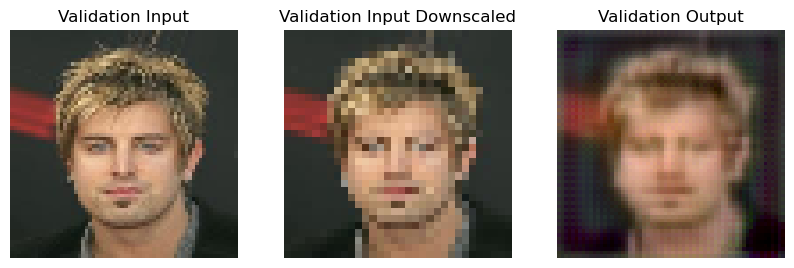

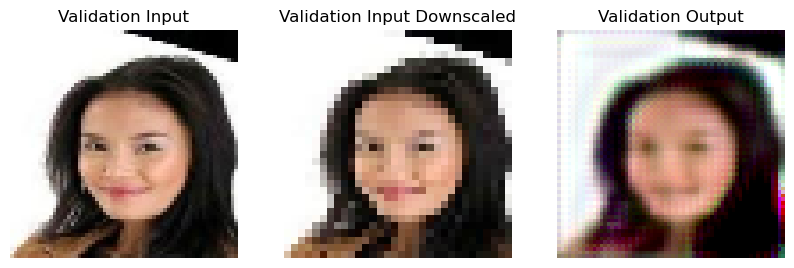

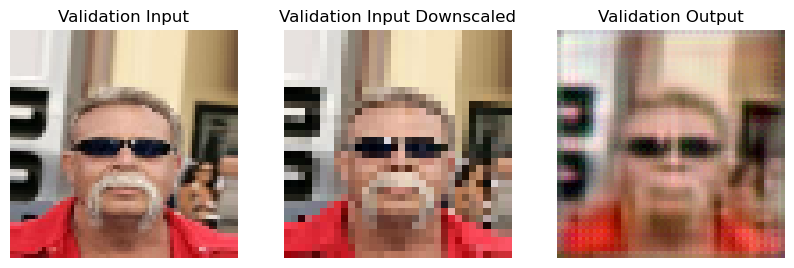

Epoch [1/1] | Train Loss: 0.0078 | Val Loss: 0.0073
Training complete.


In [12]:
num_epochs = 1
train_model(model, train_dataloader, val_dataloader, num_epochs)

Using 2 GPUs for training.


Epoch 1/1: 100%|██████████| 3008/3008 [15:05<00:00,  3.32batch/s, Train Loss=0.00389]


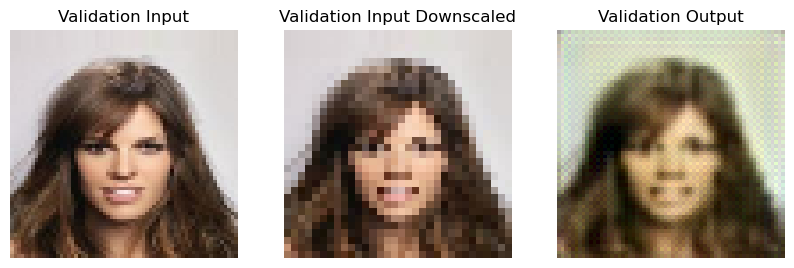

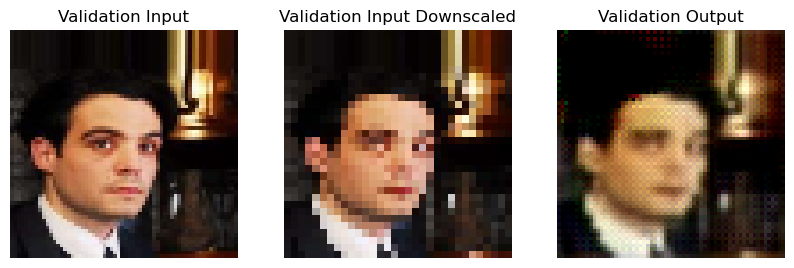

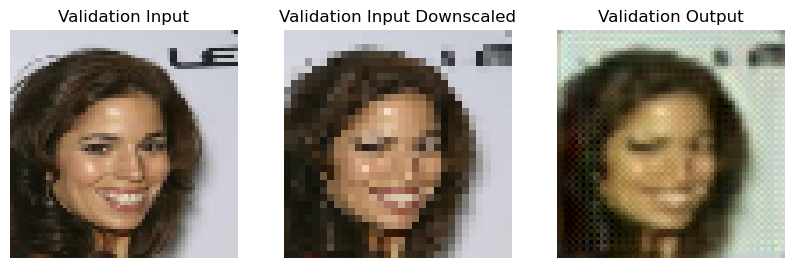

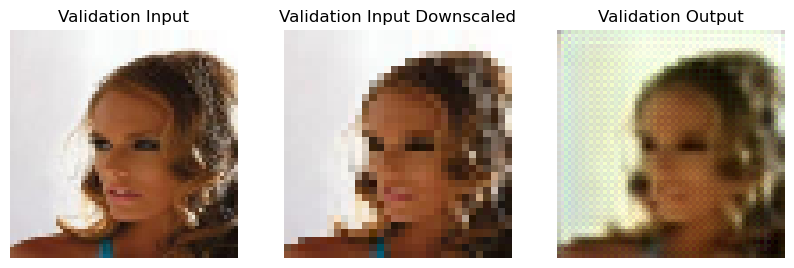

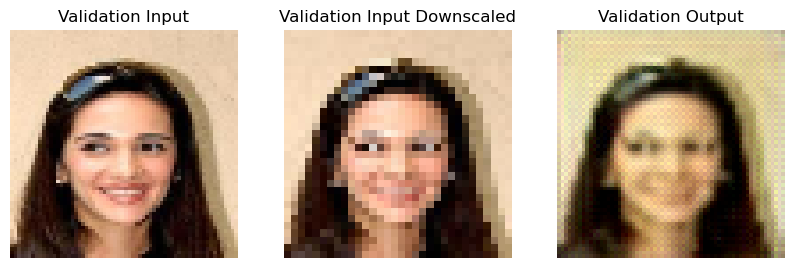

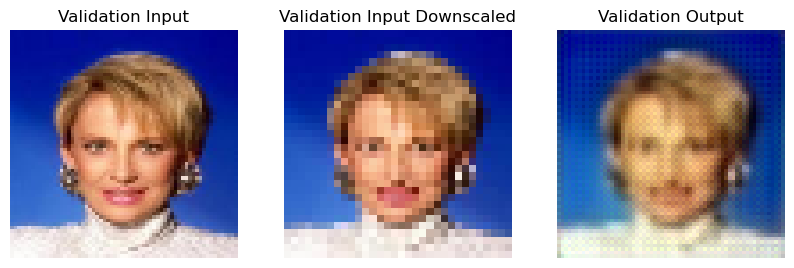

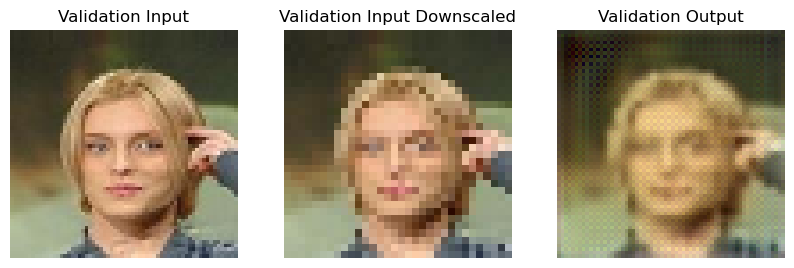

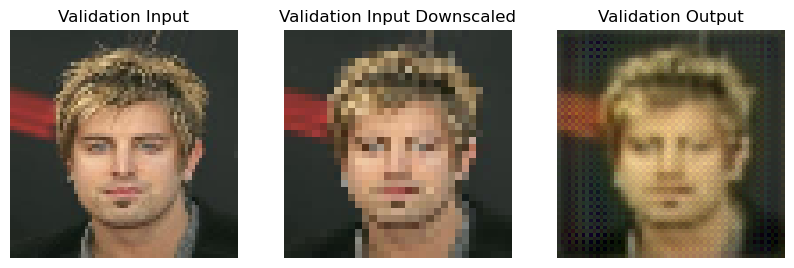

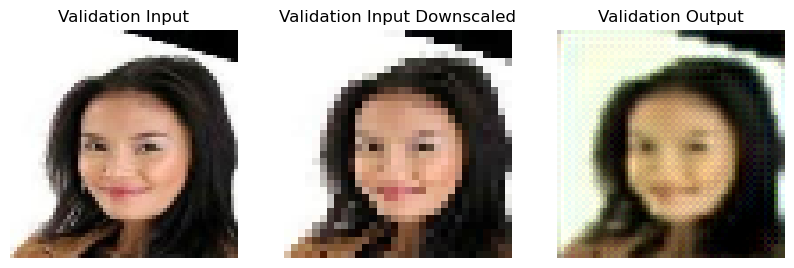

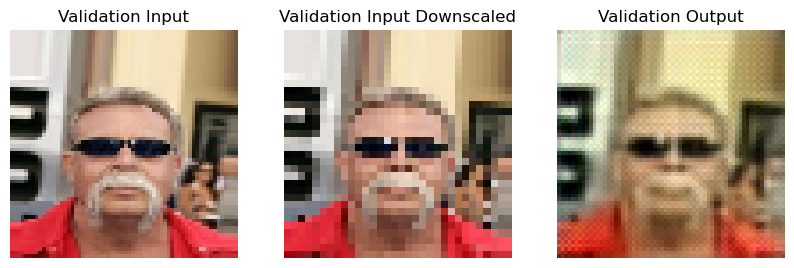

Epoch [1/1] | Train Loss: 0.0039 | Val Loss: 0.0063
Training complete.


In [13]:
num_epochs = 1
train_model(model, train_dataloader, val_dataloader, num_epochs)

Using 2 GPUs for training.


Epoch 1/1: 100%|██████████| 3008/3008 [15:09<00:00,  3.31batch/s, Train Loss=0.00293]


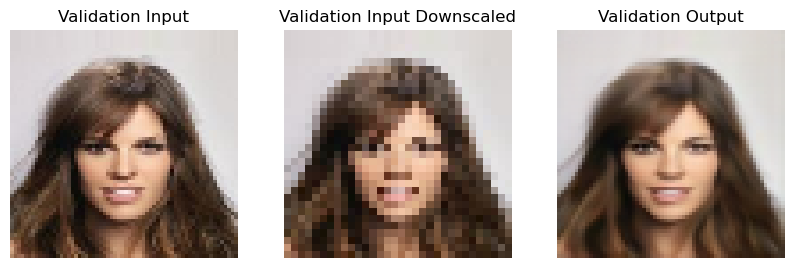

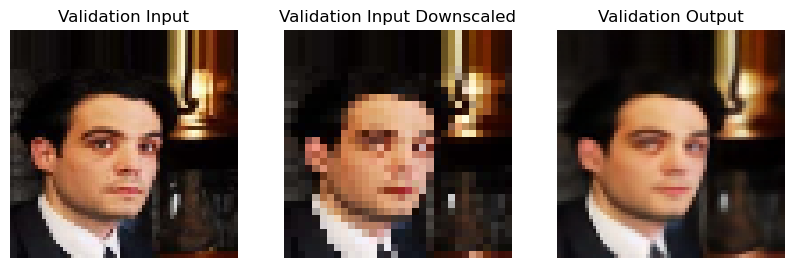

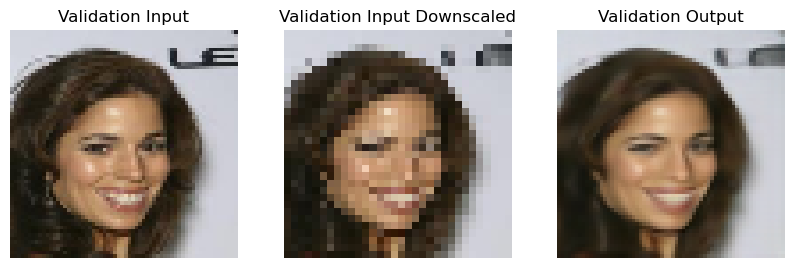

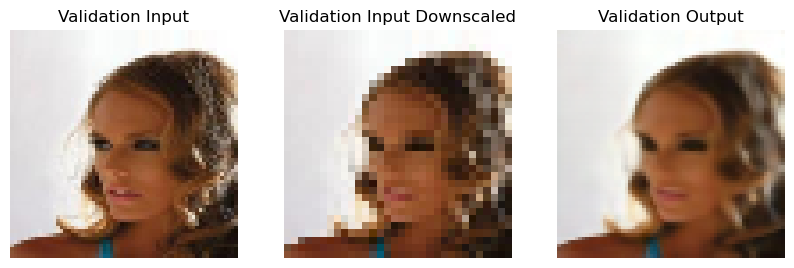

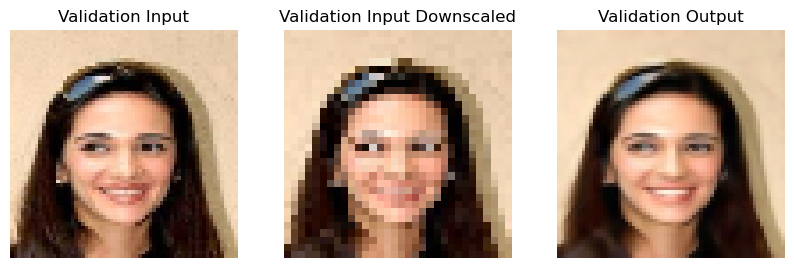

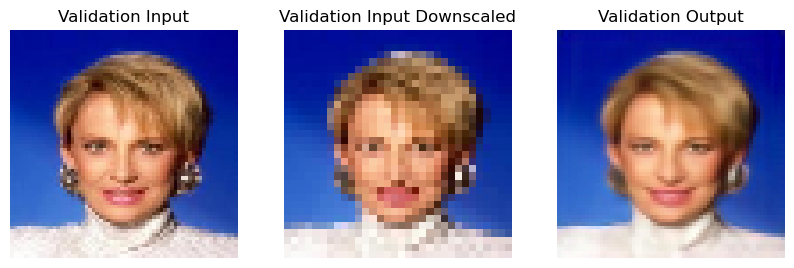

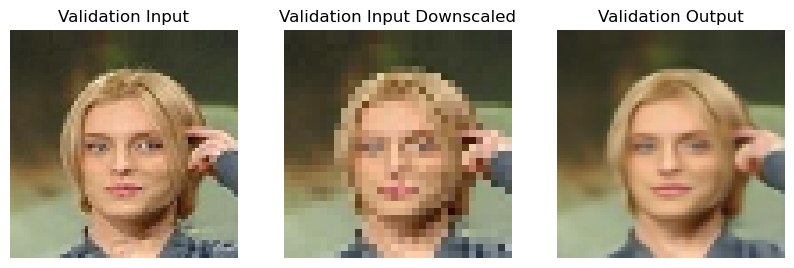

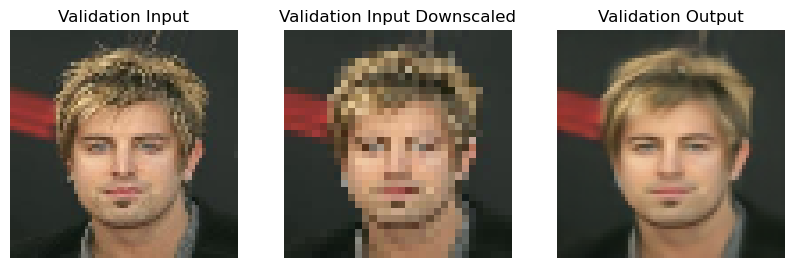

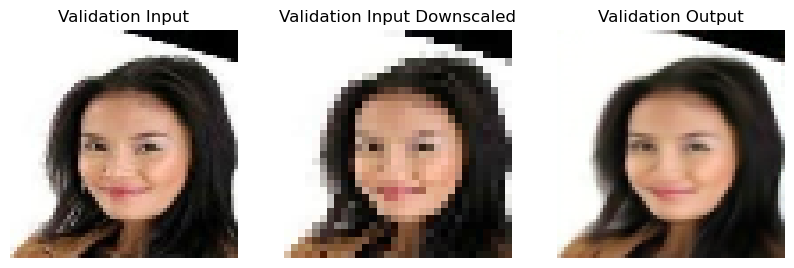

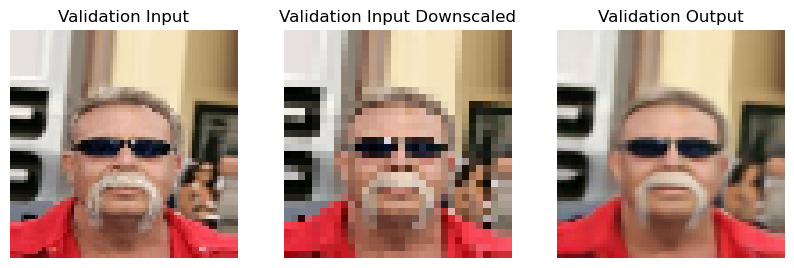

Epoch [1/1] | Train Loss: 0.0029 | Val Loss: 0.0026
Training complete.


In [14]:
num_epochs = 1
train_model(model, train_dataloader, val_dataloader, num_epochs)

In [16]:
torch.save(model, "SuperUpscale_2ep.pth")        

Using 2 GPUs for training.


Epoch 1/1: 100%|██████████| 3008/3008 [15:00<00:00,  3.34batch/s, Train Loss=0.00327]


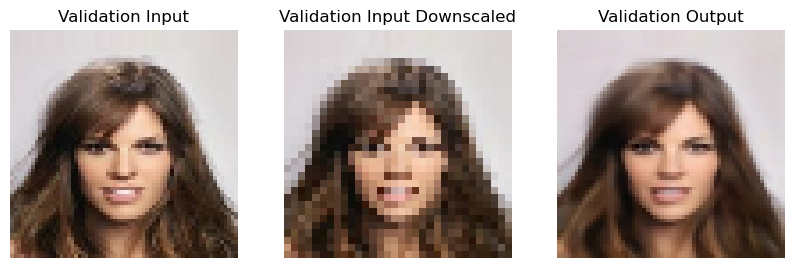

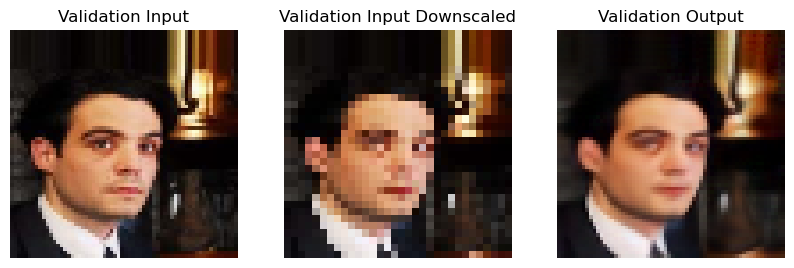

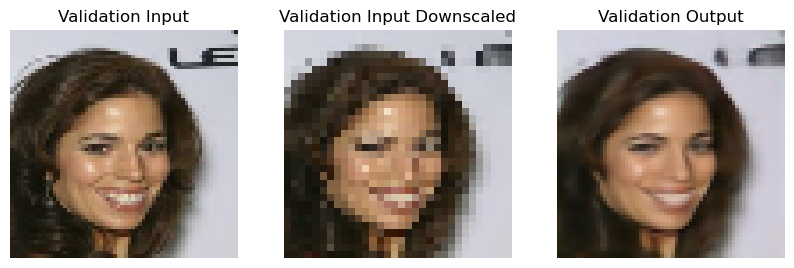

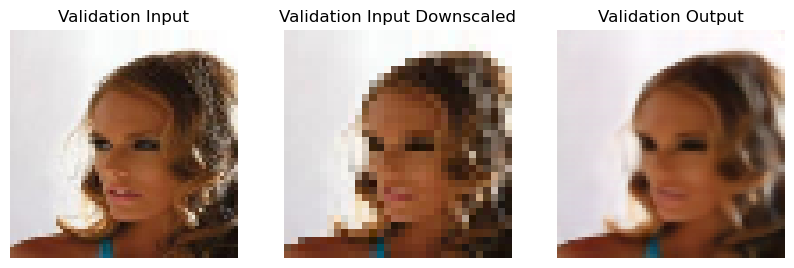

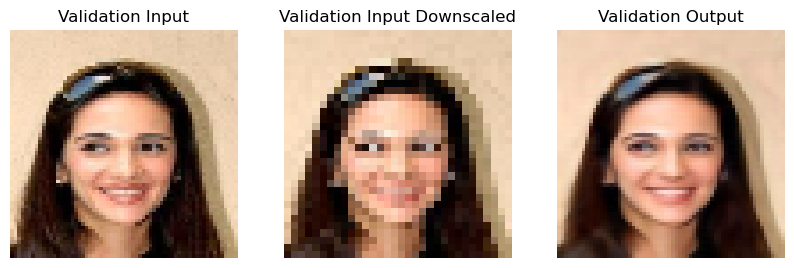

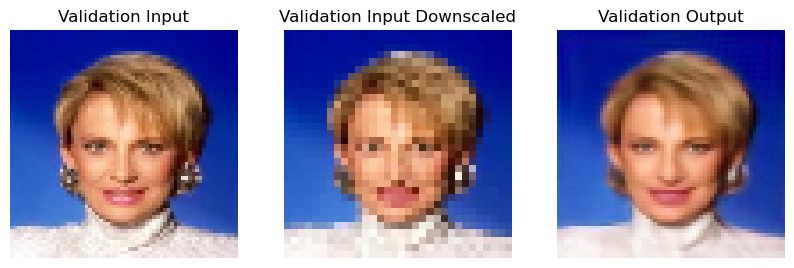

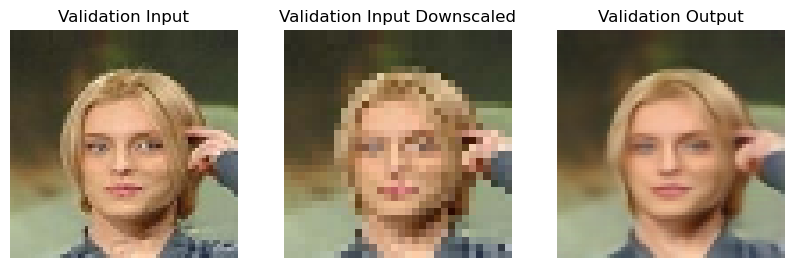

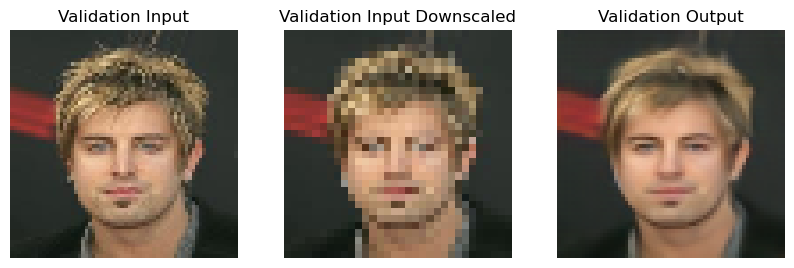

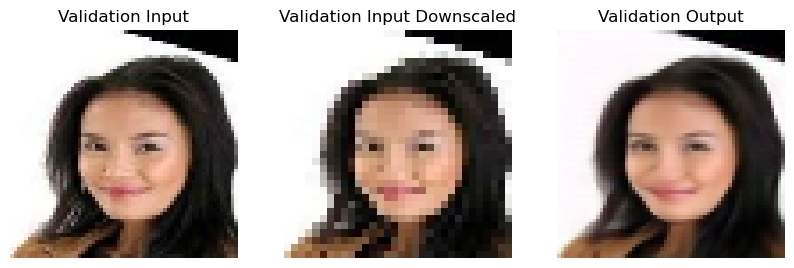

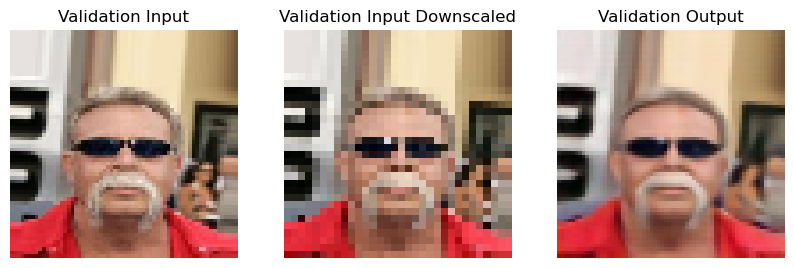

Epoch [1/1] | Train Loss: 0.0033 | Val Loss: 0.0028
Training complete.


In [17]:
num_epochs = 1
train_model(model, train_dataloader, val_dataloader, num_epochs)

Using 2 GPUs for training.


Epoch 1/1: 100%|██████████| 3008/3008 [16:19<00:00,  3.07batch/s, Train Loss=0.00311]


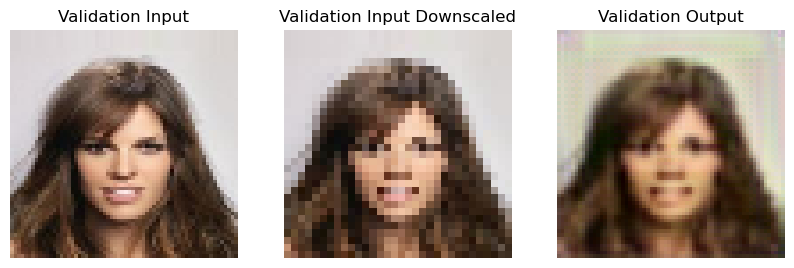

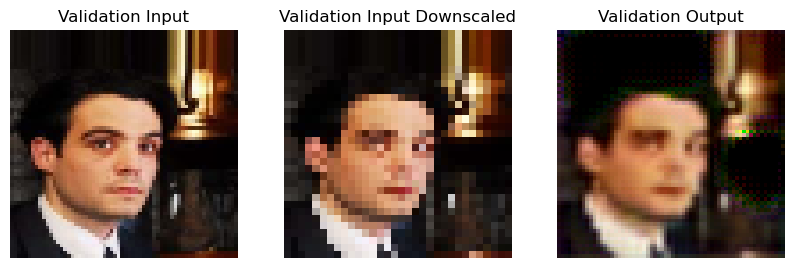

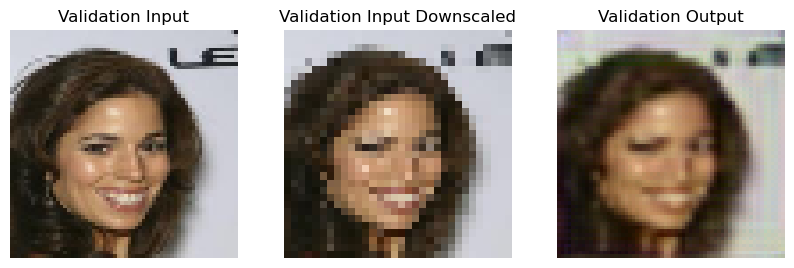

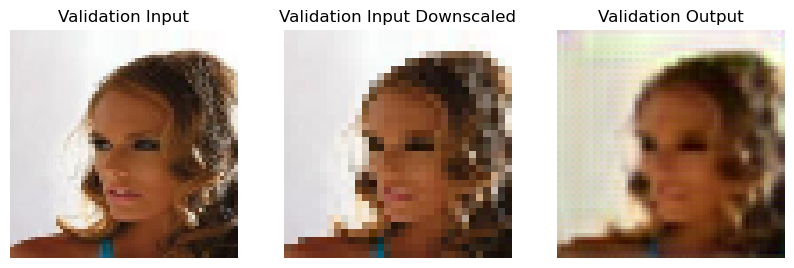

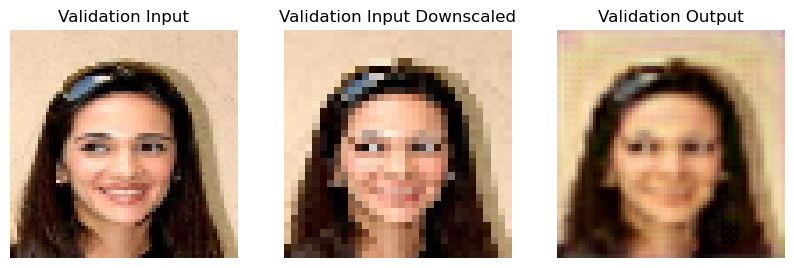

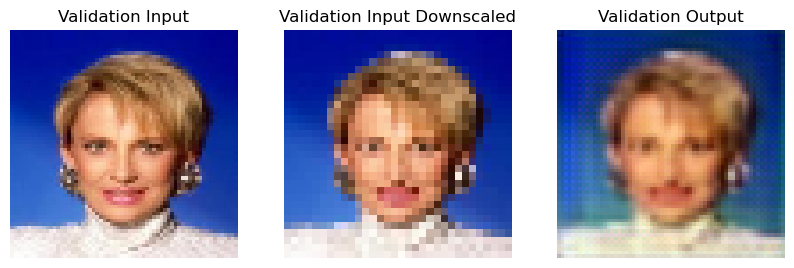

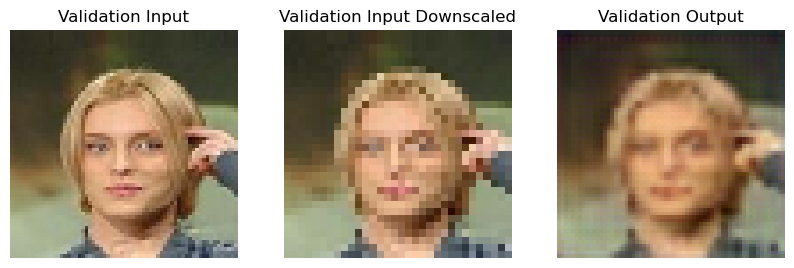

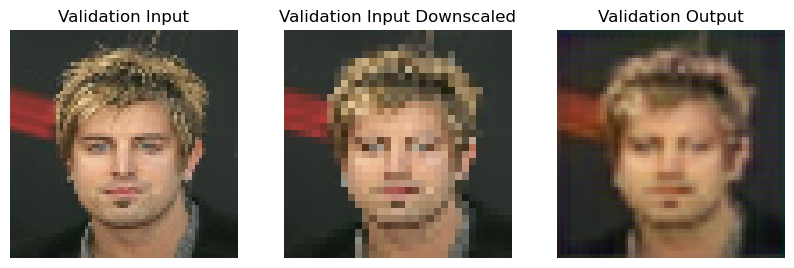

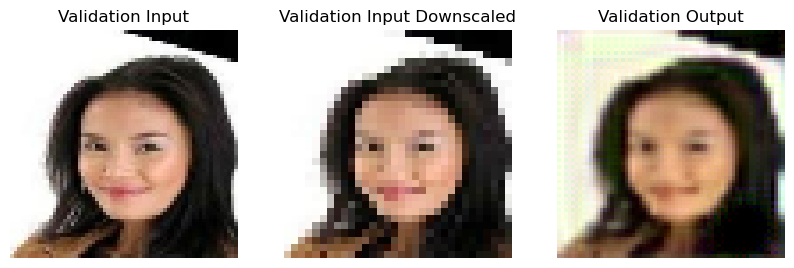

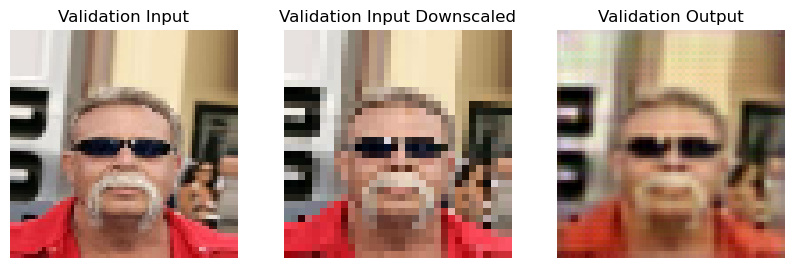

Epoch [1/1] | Train Loss: 0.0031 | Val Loss: 0.0066
Training complete.


In [18]:
num_epochs = 1
train_model(model, train_dataloader, val_dataloader, num_epochs)

Using 2 GPUs for training.


Epoch 1/1: 100%|██████████| 3008/3008 [16:18<00:00,  3.07batch/s, Train Loss=0.00286]


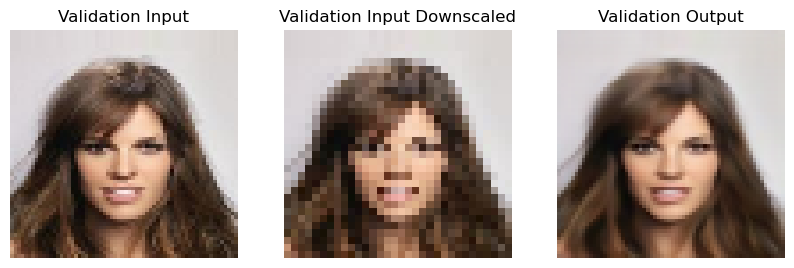

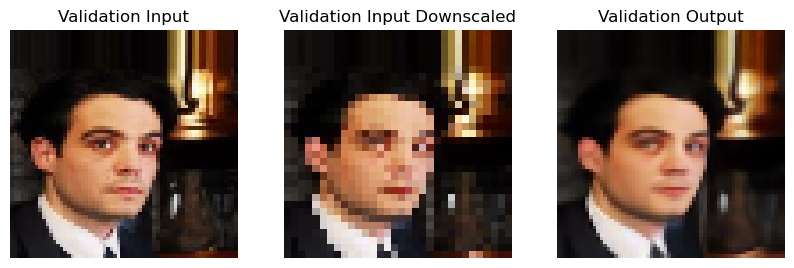

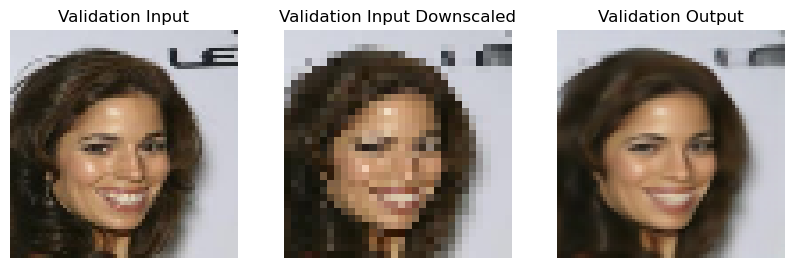

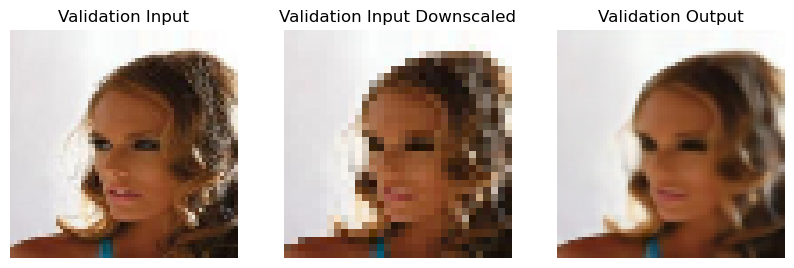

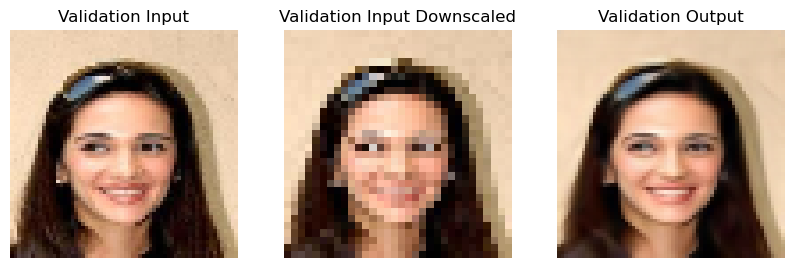

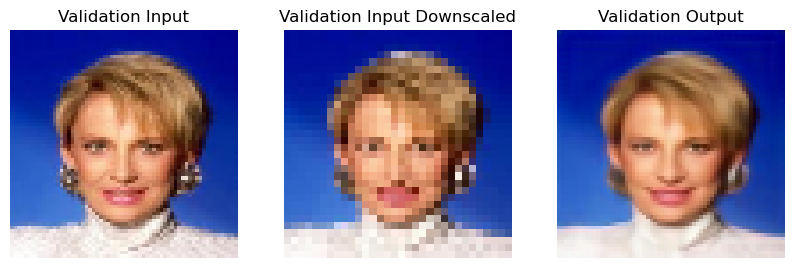

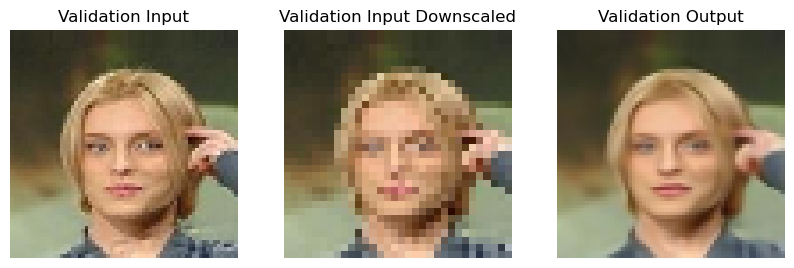

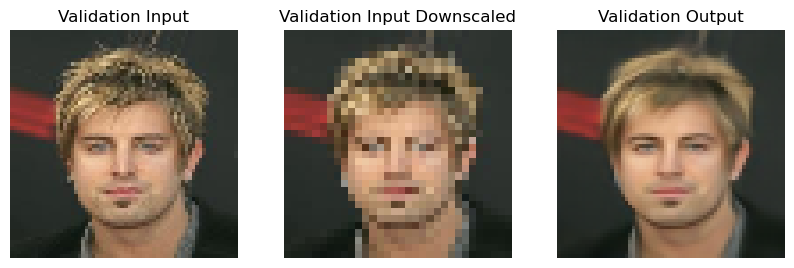

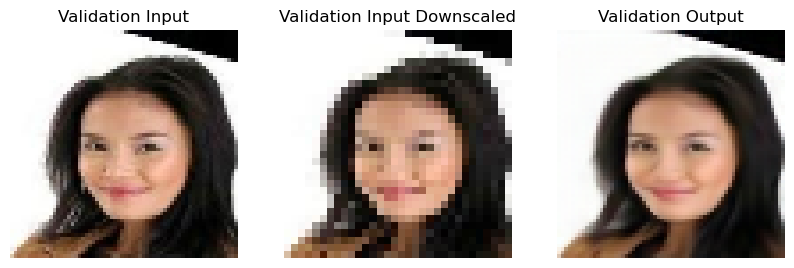

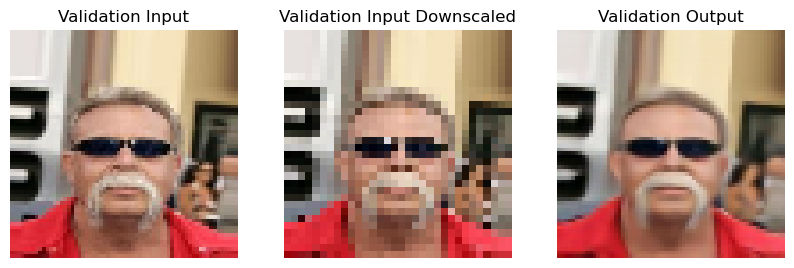

Epoch [1/1] | Train Loss: 0.0029 | Val Loss: 0.0026
Training complete.


In [19]:
num_epochs = 1
train_model(model, train_dataloader, val_dataloader, num_epochs)